# SpamSMS Classifier


Reading the Data

In [103]:
import pandas as pd

data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

In [104]:
pd.set_option('max_colwidth',100) # setting the data frame width to 100 so that we can see the text clearly
data.head()

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
1,ham,"Nah I don't think he goes to usf, he lives around here though"
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...


### Pre-processing text data
Steps for Cleaning up the text data 
1. Remove punctuation
2. Tokenization
3. Remove stopwords
4. Lemmatize

NLTK library will be used to preprocess the data



In [105]:
data.shape 

(5567, 2)

In [106]:
import nltk
import string
import re

stopwords = nltk.corpus.stopwords.words('english')
print("Stopwords", stopwords[0:10]) # sample of stopwords 
punct=string.punctuation
print("Punctuations: ",punct)

Stopwords ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Punctuations:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [107]:
ps = nltk.WordNetLemmatizer()
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.lemmatize(word) for word in tokens if word not in stopwords]
    return text
clean_text("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.Text FA to 87121 to receive!!!!!")
#All punctuation and stopwords have been removed
#while passing the data['body_text'] it will be cleaned first using clean_text function

['free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005text',
 'fa',
 '87121',
 'receive']

In [108]:
#Feature Extraction

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))
data.head()


,label,body_text,body_len,punct%
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,128,4.7
1,ham,"Nah I don't think he goes to usf, he lives around here though",49,4.1
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.,62,3.2
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,135,4.4


# Plotting new features

In [109]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

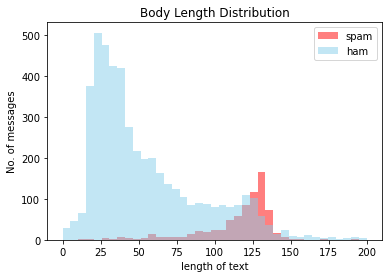

In [110]:
bins = np.linspace(0, 200, 40)

plt.hist(data[data['label']=='spam']['body_len'], bins , color='red',label='spam', alpha=0.5)
plt.hist(data[data['label']=='ham']['body_len'], bins , color='skyblue',label='ham', alpha=0.5)
plt.title("Body Length Distribution")
plt.xlabel("length of text")
plt.ylabel("No. of messages")
plt.legend(loc='upper right')
plt.show()

We can see that spam messages length is higher compared to normal ham messages 
So, these length attribute can be important feature which we can be added to original dataset and used to train model.
The graph is already distrubuted across well and no need to apply any transformations

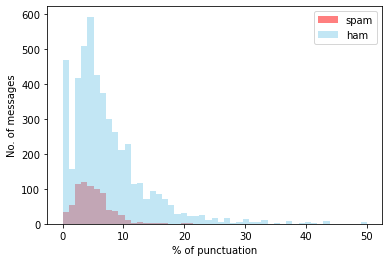

In [111]:
bins = np.linspace(0, 50, 50)

plt.hist(data[data['label']=='spam']['punct%'], bins, alpha=0.5, label='spam', color='red')
plt.hist(data[data['label']=='ham']['punct%'], bins, alpha=0.5, label='ham', color='skyblue')
plt.legend(loc='upper right')
plt.xlabel("% of punctuation")
plt.ylabel("No. of messages")
plt.show()

The graph is skewed and there are outliers so this is needed to be transformed before passing to model


**Transformed graph**

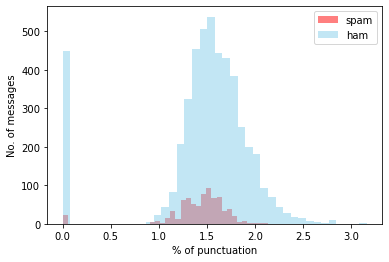

In [112]:
bins=40

plt.hist(data[data['label']=='spam']['punct%'] ** (1/4), bins, alpha=0.5, label='spam', color='red')
plt.hist(data[data['label']=='ham']['punct%']** (1/4), bins, alpha=0.5, label='ham', color='skyblue')
plt.legend(loc='upper right')
plt.xlabel("% of punctuation")
plt.ylabel("No. of messages")
plt.show()

In [113]:
data['punct%'] = data['punct%'].apply(lambda x: x**(1/4))
data.head()

,label,body_text,body_len,punct%
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,128,1.472395
1,ham,"Nah I don't think he goes to usf, he lives around here though",49,1.422971
2,ham,Even my brother is not like to speak with me. They treat me like aids patent.,62,1.337481
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,1.632355
4,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,135,1.448315


As all the features are ready we can apply this features to train our model


### Split into train/test

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

Before training the model we need vectorize (fit) the train data and transform both train and test data based on vectorized trained data

### Vectorization

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()


,body_len,punct%,0,1,2,3,4,5,6,7,...,7896,7897,7898,7899,7900,7901,7902,7903,7904,7905
0,100,1.414214,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28,2.150817,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27,2.332507,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130,1.577967,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121,1.602825,0.149171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
print(X_train_vect.shape)
print(X_test_vect.shape)
#Here only unique words in train data set are considered and in if model comes accross any new words in test data they are ignored.

(4453, 7908)
(1114, 7908)


### ML Models

### RandomForestClassifier

In [117]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix
import time

rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

st=time.time()
rf_model = rf.fit(X_train_vect, y_train)
end=time.time()
fittime=end-st

st=time.time()
y_pred = rf_model.predict(X_test_vect)
end=time.time()
predtime=end-st

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fittime: {} \nPredictTime: {} \nPrecision: {} \nRecall: {} \nAccuracy: {}'.format(
    round(fittime,4),round(predtime,4),round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

print('\nconfusion matrix :\n',confusion_matrix(y_test,y_pred))
print('\nclassification_report :\n',classification_report(y_test,y_pred))



Fittime: 6.5179 
PredictTime: 0.3596 
Precision: 1.0 
Recall: 0.882 
Accuracy: 0.984

confusion matrix :
 [[962   0]
 [ 18 134]]

classification_report :
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       962
        spam       1.00      0.88      0.94       152

    accuracy                           0.98      1114
   macro avg       0.99      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



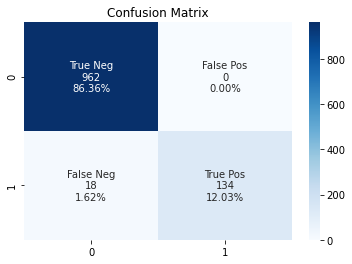

In [135]:
import seaborn as sns
cf_matrix=confusion_matrix(y_test,y_pred)

labels = ['True Neg','False Pos','False Neg','True Pos']
count = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
percentage = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,count,percentage)]
labels = np.asarray(labels).reshape(2,2)
cm=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### Gradient Boosting Classifier

In [136]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_predgb = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_predgb, pos_label='spam', average='binary')
print('Fittime: {} \nPredictTime: {} \n Precision: {} \nRecall: {} \nAccuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_predgb==y_test).sum()/len(y_predgb), 3)))


Fittime: 501.837 
PredictTime: 0.402 
 Precision: 0.932 
Recall: 0.901 
Accuracy: 0.978



confusion matrix :
 [[952  10]
 [ 15 137]]

classification_report :
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       962
        spam       0.93      0.90      0.92       152

    accuracy                           0.98      1114
   macro avg       0.96      0.95      0.95      1114
weighted avg       0.98      0.98      0.98      1114



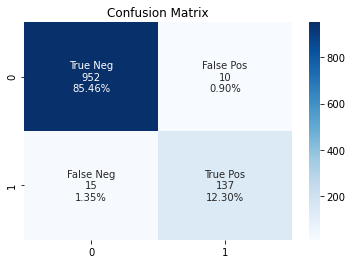

In [137]:
print('\nconfusion matrix :\n',confusion_matrix(y_test,y_predgb))
print('\nclassification_report :\n',classification_report(y_test,y_predgb))
cf_matrix=confusion_matrix(y_test,y_predgb)

labels = ['True Neg','False Pos','False Neg','True Pos']
count = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
percentage = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,count,percentage)]
labels = np.asarray(labels).reshape(2,2)
cm=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

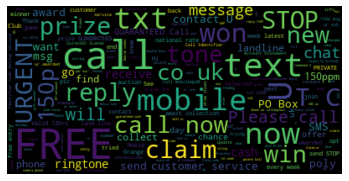

In [147]:
#to visualize most prominent words used in spam messages
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
spam_words=data[data['label']=='spam']['body_text']
spam_wordsc=' '.join(list(spam_words))
wordcloud = WordCloud(max_font_size=50, background_color="black").generate(spam_wordsc)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Conclusion:
    Both the models precision, accuracy, recall is around same but
    As this is the spam SMS filter we don't want our spam filter to classify our original messages as spam. So here False positives are costly
    So, compared to GradientBoosting Random Forest Classifier gave results which as more precision i.e, 100%.
    So, Random Forest model works best with this dataset to predict Spam Messages